# Niger/Millet DEV

# Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

## 1. Defining simulation dates

In [2]:
date_start = datetime.date(2016,5,1)
duration = 220

## 2. Preparing the base dataset

In [3]:
# import zipfile

# path_to_zip_file = "../data/exemple_data/exemple_data_niger_2017.zip"
# directory_to_extract_to = "../data/exemple_data/"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [4]:
# we provide the path to the example data
# rainfall_data_path = "../data/exemple_data/TAMSAT_v3.1_niger_rfe_filled/"
# climate_data_path = "../data/exemple_data/AgERA5_niger/"

# alternatively, tap into the climate data that we already have retrieved for Niger, 1983-2022
rainfall_data_path = "/mnt/d/climate_database/TAMSAT_v3.1_niger_rfe_filled_1983_2021_DL20230614/"
climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/"

In [5]:
grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)
print("The grid is {} pixels wide by {} pixels high.".format(grid_width, grid_height))

The grid is 333 pixels wide by 437 pixels high.


In [6]:
# initialize empty xarray dataset
base_data = xr.Dataset()

# load rainfall and weather data
base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


# on trafique le load_isda

In [76]:
# load soil parameters
# base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

# on trafique le load_iSDA_soil_data

data = base_data.copy()

# loading soil depth data
# soil data is Africa SoilGrids - Root zone depth (cm) 
# reference of the dataset is https://data.isric.org/geonetwork/srv/fre/catalog.search#/metadata/c77d1209-56e9-4cac-b76e-bbf6c7e3a617
# reference publication : https://doi.org/10.1016/j.geoderma.2018.02.046
soil_depth_file_path = "../data/assets/gyga_af_erzd__m_1km.tif"
dataarray = rioxarray.open_rasterio(soil_depth_file_path)
dataarray = dataarray.astype('float32') # converting to float32 to allow for NaNs
dataarray = dataarray.rio.reproject_match(data, nodata=np.nan) # reprojecting to match the base data
dataarray = dataarray.squeeze("band").drop_vars(["band"]) # removing the band dimension and variable
dataarray = dataarray * 10 # converting from cm to mm
data["profRu"] = dataarray # we add the soil depth data to the base data
data["profRu"].attrs = {"units": "mm", "long_name": "Soil root zone depth (mm) adapted from Africa SoilGrids RZD"}
del dataarray # we delete the temporary dataarray


# defining the soil surface reservoir depth with default values
data["epaisseurSurf"] = 100 * xr.ones_like(data["profRu"])
data["epaisseurSurf"].attrs = {"units": "mm", "long_name": "Soil surface reservoir depth (mm)"}


# defining the initial water stock in the deep surface reservoir
data["stockIniProf"] = 0 * xr.ones_like(data["profRu"])
data["stockIniProf"].attrs = {"units": "mm", "long_name": "Initial water stock in the deep surface reservoir (mm)"}


# loading soil texture data
# soil data is adapted from iSDA Africa - USDA Soil Texture Class
# reference of the original dataset is https://zenodo.org/record/4094616
# reference of the adapted dataset is https://doi.org/10.18167/DVN1/YSVTS2 
soil_texture_class_file_path = "../data/assets/iSDA_at_TAMSAT_resolution_zeroclass_1E6.tif"
dataarray = rioxarray.open_rasterio(soil_texture_class_file_path)
dataarray = dataarray.rio.reproject_match(data, nodata=np.nan) # reprojecting to match the base data
dataarray = dataarray.squeeze("band").drop_vars(["band"]) # removing the band dimension and variable
dataarray.attrs = {"units":"arbitrary", "long_name":"soil_type"} # adding attributes

data["soil_type"] = dataarray # add soil type identifier to the dataset
data["soil_type"] = data["soil_type"] / 1000000 # conversion from 1E6 to 1E0
data["soil_type"] = data["soil_type"].astype("float32")

# load correspondance table
path_soil_type_correspondance = "../data/assets/TypeSol_Moy13_HWSD.csv"
df_soil_type_correspondance = pd.read_csv(path_soil_type_correspondance, sep=";", skiprows=1)

# correspondance between soil properties naming in the csv file and in the dataset
soil_variables = {
    "seuilRuiss" : "SeuilRuiss", # utilisé dans bilan_hydro.estimate_runoff pour le calcul de lr
    "pourcRuiss" : "PourcRuiss", # utilisé dans bilan_hydro.estimate_runoff pour le calcul de lr
}

# create maps of soil properties and add them to the dataset
for soil_variable in soil_variables :
    dict_values = dict(zip(df_soil_type_correspondance["Id"], df_soil_type_correspondance[soil_variables[soil_variable]]))
    dict_values[0] = np.nan
    soil_types_converted = np.reshape([dict_values[x.astype(int)] for x in data["soil_type"].to_numpy().flatten()], (grid_width, grid_height))
    data[soil_variable] = (data["soil_type"].dims,soil_types_converted)
    data[soil_variable] = data[soil_variable].astype("float32")
    # TODO: add dataarray.attrs = {} to precise units and long_name

# converting pourcRuiss to decimal %
data["pourcRuiss"] = data["pourcRuiss"] / 100
del dataarray # we delete the temporary dataarray


# loading RU
soil_RZPAWC_file_path = "../data/assets/gyga_af_agg_erzd_tawcpf23mm__m_1km.tif"
dataarray = rioxarray.open_rasterio(soil_RZPAWC_file_path)
dataarray = dataarray.astype('float32')
dataarray = dataarray.rio.reproject_match(data, nodata=np.nan) # reprojecting to match the base data
dataarray = dataarray.squeeze("band").drop_vars(["band"]) # removing the band dimension and variable
dataarray.attrs = {"units":"mm", "long_name":"Root zone plant available water capacity (mm)"} # adding attributes
data["RZPAWC"] = dataarray # add soil type identifier to the dataset
del dataarray # we delete the temporary dataarray

#calculating RU (mm/m)
data["ru"] = data["RZPAWC"] / (data["profRu"]/1000)

In [ ]:
# # determine the boundaries of the data xarray before cropping
xmin, ymin, xmax, ymax = data.rio.set_spatial_dims(x_dim="x", y_dim="y").rio.bounds()

# # crop to the area of interest
dataarray = dataarray.where((dataarray.y < ymax)
                            & (dataarray.y > ymin)
                            & (dataarray.x > xmin)
                            & (dataarray.x < xmax)
                        ).dropna(dim='y', how='all').dropna(dim='x', how='all')

# resample to match the grid resolution
dataarray = dataarray.rio.reproject_match(data, nodata=np.nan)
dataarray = dataarray.squeeze("band").drop_vars(["band"])
dataarray.attrs = {"units":"arbitrary", "long_name":"soil_type"}

# add soil type identifier to the dataset
data["soil_type"] = dataarray
data["soil_type"] = data["soil_type"] / 1000000 # conversion from 1E6 to 1E0
data["soil_type"] = data["soil_type"].astype("float32")

# load correspondance table
path_soil_type_correspondance = "../data/assets/TypeSol_Moy13_HWSD.csv"
df_soil_type_correspondance = pd.read_csv(path_soil_type_correspondance, sep=";", skiprows=1)

# correspondance between soil properties naming in the csv file and in the dataset
soil_variables = {
    "epaisseurProf" : "EpaisseurProf", # utilisé dans bilan_carbo.initialize_simulation et bilan_hydro.InitPlotMc pour le calcul de profRu / initPlotMc a l'air d'avoir été remplacé par initializeSimulation
    "epaisseurSurf" : "EpaisseurSurf", # utilisé dans bilan_carbo.initialize_simulation pour le calcul de surface_tank_capacity et de profRu et dans bilan_hydro.InitPlotMc pour le calcul de profRu
    "stockIniProf" : "StockIniProf", # utilisé dans bilan_carbo.initialize_simulation pour le calcul de total_tank_stock, pareil dans bilan_hydro.InitPlotMc
    # "stockIniSurf" : "StockIniSurf", # ne semble pas être utilisé dans le modèle
    "seuilRuiss" : "SeuilRuiss", # utilisé dans bilan_hydro.estimate_runoff pour le calcul de lr
    "pourcRuiss" : "PourcRuiss", # utilisé dans bilan_hydro.estimate_runoff pour le calcul de lr
    "ru" : "Ru", # utilisé dans bilan_carbo.initialize_simulation pour le calcul du root_tank_capacity, dans initPlotMc pour calculer root_tank_capacity et surface_tank_capacity, et d'autres. 
}

# create maps of soil properties and add them to the dataset
for soil_variable in soil_variables :
    dict_values = dict(zip(df_soil_type_correspondance["Id"], df_soil_type_correspondance[soil_variables[soil_variable]]))
    dict_values[0] = np.nan
    soil_types_converted = np.reshape([dict_values[x.astype(int)] for x in data["soil_type"].to_numpy().flatten()], (grid_width, grid_height))
    data[soil_variable] = (data["soil_type"].dims,soil_types_converted)
    data[soil_variable] = data[soil_variable].astype("float32")
    # TODO: add dataarray.attrs = {} to precise units and long_name

# converting pourcRuiss to decimal %
data["pourcRuiss"] = data["pourcRuiss"] / 100

# on déplace ici le calcul de profRu
#! data["profRu"] = data["epaisseurProf"] + data["epaisseurSurf"]
# au final on peut charger directement la profondeur de la réserve utile depuis un dataset
# i.e. gyga_af_erzd__m_1km root zone depth (cm)
data["profRu"] = #! read from a dataset
data["profRu"].attrs = {"units": "mm", "long_name": "Soil maximal depth"}

# on continue

In [7]:
base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

In [8]:
# compute day length raster
base_data = calc_day_length_raster_fast(base_data, date_start, duration)

In [9]:
base_data

<xarray.Dataset>
Dimensions:        (x: 437, y: 333, time: 220)
Coordinates:
  * x              (x) float64 -0.4875 -0.45 -0.4125 ... 15.79 15.83 15.86
  * y              (y) float64 23.77 23.74 23.7 23.66 ... 11.44 11.4 11.36 11.32
    spatial_ref    int64 0
Dimensions without coordinates: time
Data variables: (12/13)
    rain           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tpMoy          (time, y, x) float32 nan nan nan nan ... 27.83 27.83 28.0
    ET0            (time, y, x) float32 nan nan nan nan ... 3.527 3.527 3.475
    rg             (time, y, x) float32 nan nan nan nan ... 21.26 21.26 21.28
    profRu         (y, x) float32 nan nan nan nan ... 400.0 400.0 750.0 750.0
    epaisseurSurf  (y, x) float32 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0
    ...             ...
    soil_type      (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 6.0 6.0 6.0 6.0 6.0
    seuilRuiss     (y, x) float32 nan nan nan nan nan ... 15.0 15.0 15.0 15.0
    pourcRuiss     (y, x) float32 nan nan nan nan nan ... 0.35 0.35 0.35 0.35
    RZPAWC         (y, x) float32 nan nan nan nan nan ... 30.0 30.0 52.0 60.0
    ru             (y, x) float32 nan nan nan nan nan ... 75.0 75.0 69.33 80.0
    dureeDuJour    (time, y, x) float64 13.04 13.04 13.04 ... 11.48 11.48 11.48

## 3. Preparing a simulation dataset

In [10]:
# parameter file names
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# load variety, cropping system and soil parameters
paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

In [11]:
# creato,g simulation xarray dataset by copying the base data
data = base_data.copy()

# initializing all the necessary variables
data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
data = initialize_default_irrigation(data)
data = calculate_once_daily_thermal_time(data, paramVariete)

In [12]:
data

<xarray.Dataset>
Dimensions:                             (x: 437, y: 333, time: 220)
Coordinates:
  * x                                   (x) float64 -0.4875 -0.45 ... 15.86
  * y                                   (y) float64 23.77 23.74 ... 11.36 11.32
    spatial_ref                         int64 0
Dimensions without coordinates: time
Data variables: (12/113)
    rain                                (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    tpMoy                               (time, y, x) float32 nan nan ... 28.0
    ET0                                 (time, y, x) float32 nan nan ... 3.475
    rg                                  (time, y, x) float32 nan nan ... 21.28
    profRu                              (y, x) float32 nan nan ... 750.0 750.0
    epaisseurSurf                       (y, x) float32 100.0 100.0 ... 100.0
    ...                                  ...
    sumPP                               (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    TigeUp                              (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    UBTCulture                          (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    lai                                 (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    Ncrit                               (time, y, x) float32 0.0 0.0 ... 0.0 0.0
    irrigation                          (time, y, x) float32 0.0 0.0 ... 0.0 0.0

## 4. Running the model

In [13]:
data = run_model(paramVariete, paramITK, paramTypeSol, data, duration)

100%|██████████| 220/220 [04:07<00:00,  1.13s/it]


## 5. Mapping results

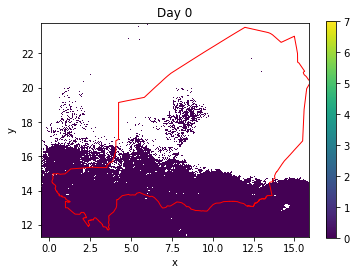

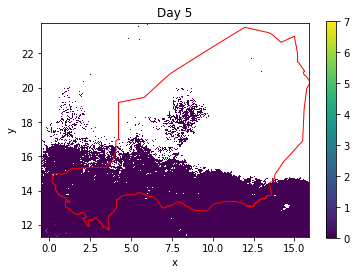

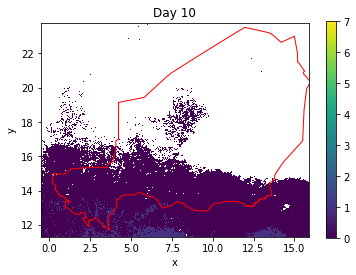

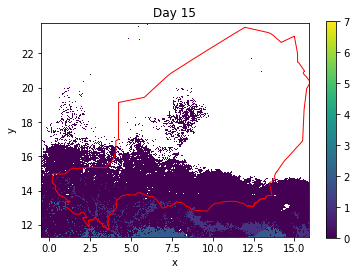

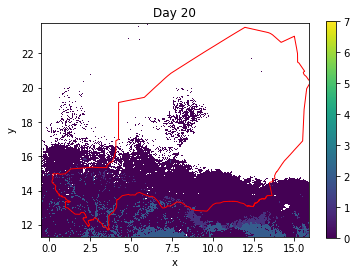

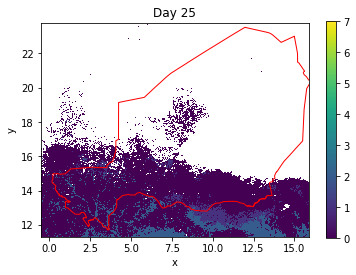

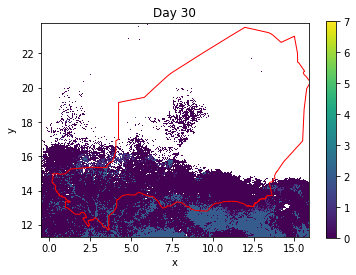

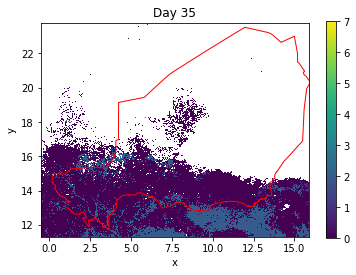

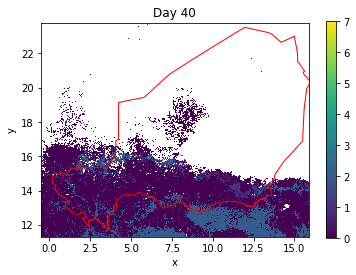

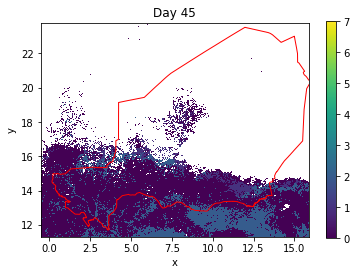

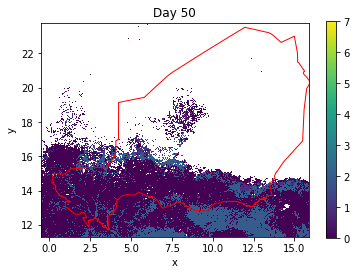

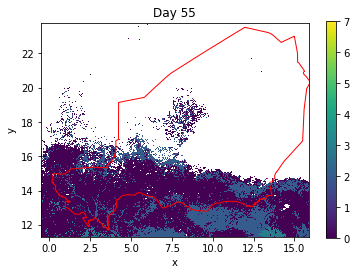

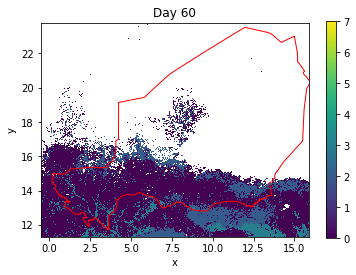

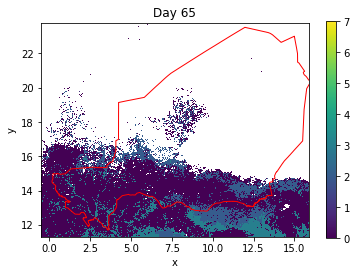

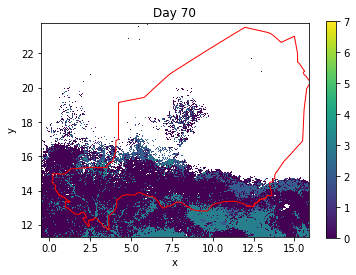

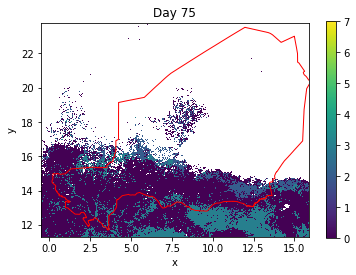

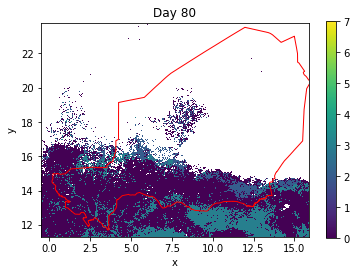

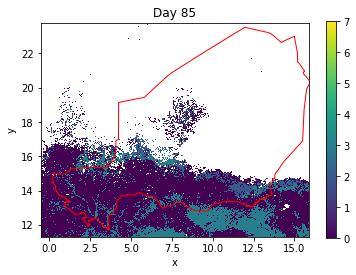

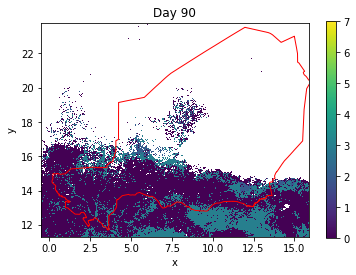

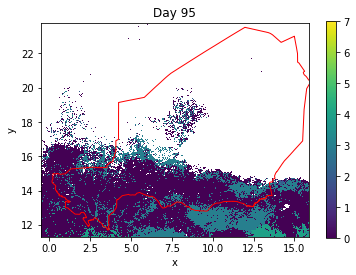

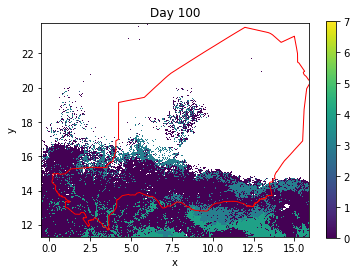

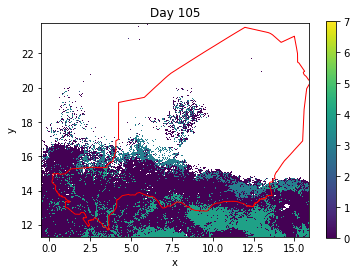

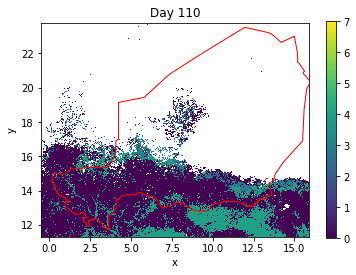

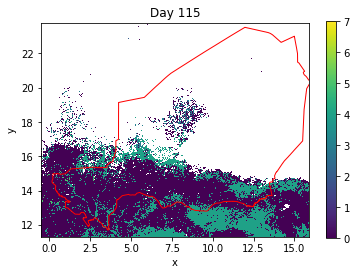

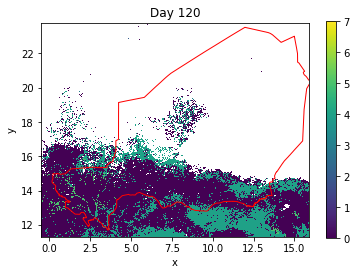

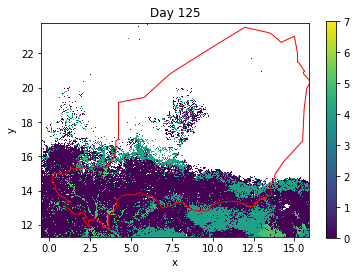

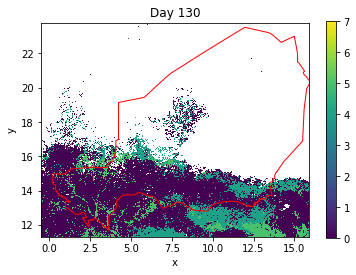

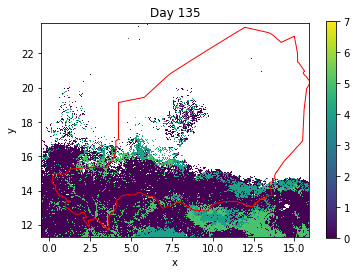

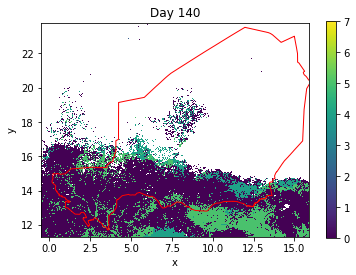

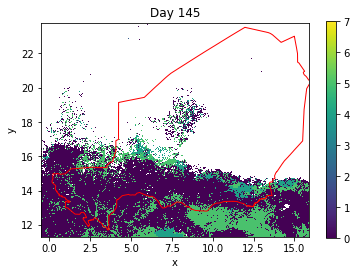

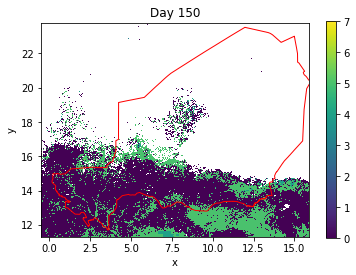

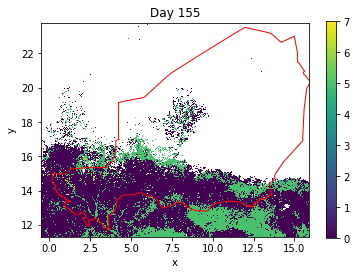

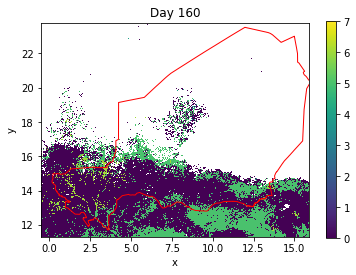

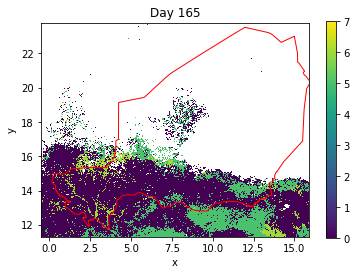

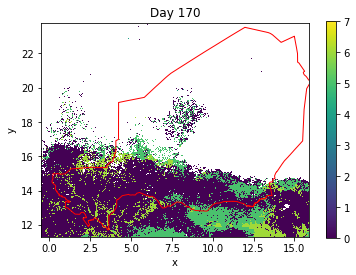

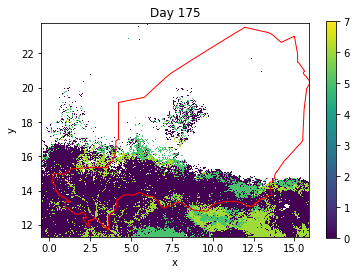

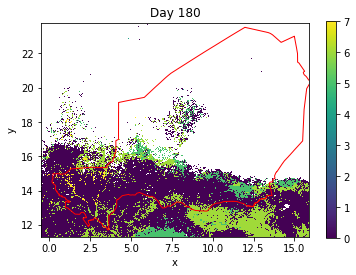

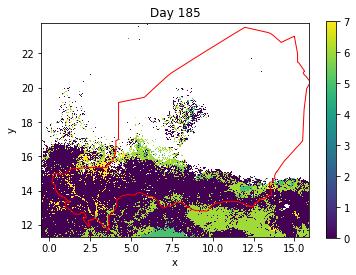

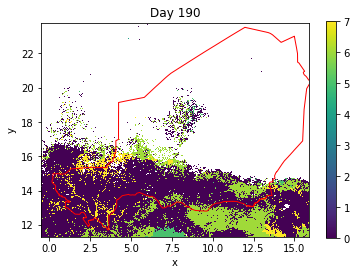

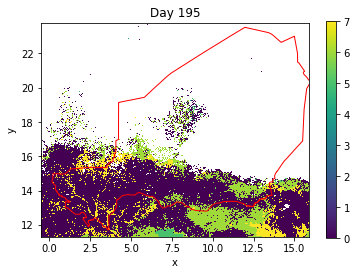

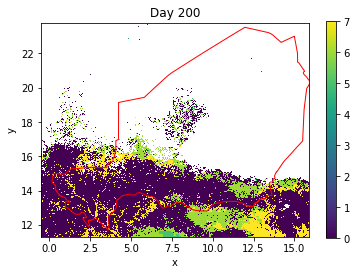

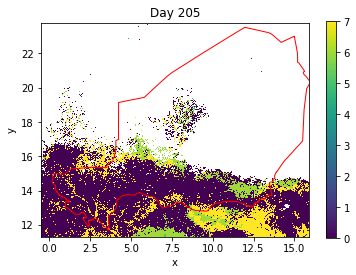

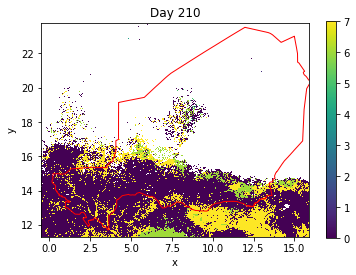

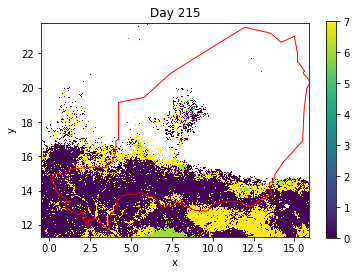

In [14]:
variable = "numPhase"
time_resolution = 5
vmax = data[variable].max().values
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
for i in range(int(round(duration/time_resolution,0))):
    # data[variable][time_resolution*i,:,:].plot(vmin=0, vmax=vmax)
    xr.where(np.isnan(data["ru"]),np.nan,data[variable][time_resolution*i,:,:]).plot(vmin=0, vmax=vmax)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.title("Day %s" % (i*time_resolution))
    plt.show()

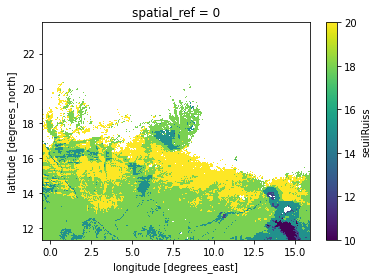

In [22]:
data["seuilRuiss"].plot()

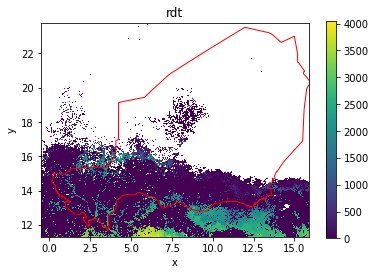

In [15]:
variable = "rdt"
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")

xr.where(np.isnan(data["ru"]),np.nan,data[variable][-1,:,:]).plot()
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.title("%s" % (variable))
plt.show()